In [2]:
###### import requests
import json
import time
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy.random as rng

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, Input, concatenate,MaxPooling1D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K


In [4]:
def slitDataSetWithSize(dataset,size):
    dataLen = dataset.shape[0]
    lsRs = []
    for e in range(0,(dataLen//size)):
        lsRs.append(dataset[e*size:(e+1)*size].to_numpy())
    if (dataLen % size > 0):
        lsRs.append(dataset[(dataLen-size):(dataLen)].to_numpy())
    return np.array(lsRs)
def slipDataAndLabel(rs1,slitIndex):

    labelaf = rs1[:,:,(slitIndex):(slitIndex+1)]
    dataaf = np.delete(rs1, np.s_[(slitIndex):(slitIndex+1)], 2)

    return (dataaf,labelaf[:,1].reshape(dataaf.shape[0]))

# a = pd.DataFrame([[1,1,3],[4,1,6],[7,0,9],[10,0,12],[13,1,15],[16,1,18],[19,1,21]])
# rs1 = slitDataSetWithSize(a,2)
# (datat,datal) = slipDataAndLabel(rs1,1)
# print(datat)
# print(datal)

In [5]:
def viewAllDataFromFolder(dataPath):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        count = count + 1
        dataItem = pd.read_pickle(dataPath+"/"+fs)
        dataItem["FileIndex"]=count
        dataList.append(dataItem)
    frame = pd.concat(dataList)
    frame = frame.reset_index().fillna(0)
    frame["node"] = frame["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
    return (frame,count)

def slitDataSetToNP(frame,count,size):
#     print(frame.shape)
#     print(count)
#     print(len(onlyfiles))
    lsNP = np.array([])
    for cc in range(1,count+1):
        dfn = frame[frame['FileIndex']==cc]
        datasort = dfn.sort_values(by=['timestamp'])
        rsNP = slitDataSetWithSize(datasort,size)
        if lsNP.size==0 :
            lsNP = rsNP
        else :
            lsNP = np.append(lsNP, rsNP, axis=0)
#         print(rsNp.shape)
    return lsNP

def normalizeColumn(datas,fromCol,toCol):
    cols = datas.columns
    for e in range(fromCol,toCol):
        normalized_df=(datas[cols[e]]-datas[cols[e]].mean())/datas[cols[e]].std()
        datas[cols[e]] = normalized_df
    return datas

In [6]:
(dataset,filecount) = viewAllDataFromFolder("CBT/data")

In [7]:
dataset.head()

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,disk_space_used,net_received,net_transmit,node,label,FileIndex
0,1.625210e+09,0.055000,0.758333,0.171000,0.001000,9.0,0.70,2.641199e+09,1.444844e+09,0.006933,0.590030,605856.533333,8.034681e+06,2,1,1
1,1.625210e+09,0.055000,0.758333,0.171000,0.001000,9.0,0.70,2.641199e+09,1.444844e+09,0.006933,0.590030,605856.533333,8.034681e+06,2,1,1
2,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1
3,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1
4,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1


In [8]:
datasetnorm = normalizeColumn(dataset,1,12)

In [9]:
datanp = slitDataSetToNP(datasetnorm,filecount,60)
datanp = np.delete(datanp, np.s_[(0):(1)], 2)#Remove timestamp
datanp = np.delete(datanp, np.s_[(12):(13)], 2)#Remove node
datanp = np.delete(datanp, np.s_[(13):(14)], 2)#Remove file index

In [10]:
datanp

array([[[-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
         -4.67563376e-01,  8.03468107e+06,  1.00000000e+00],
        [-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
         -4.67563376e-01,  8.03468107e+06,  1.00000000e+00],
        [-9.19028615e-01,  1.72955666e+00, -9.99652344e-01, ...,
         -4.44000022e-01,  8.79495787e+06,  1.00000000e+00],
        ...,
        [-9.01131876e-01,  1.74063109e+00, -1.03053970e+00, ...,
         -4.54010597e-01,  9.03273227e+06,  1.00000000e+00],
        [-9.01131876e-01,  1.74063109e+00, -1.03053970e+00, ...,
         -4.54010597e-01,  9.03273227e+06,  1.00000000e+00],
        [-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
         -4.43929522e-01,  1.05392453e+07,  1.00000000e+00]],

       [[-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
         -4.43929522e-01,  1.05392453e+07,  1.00000000e+00],
        [-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
         -4.43929522e-01,  1.05392453e

In [11]:
(datatrain,datalabel) = slipDataAndLabel(datanp,12)

In [12]:
datatrain

array([[[-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
          1.39254028e-01, -4.67563376e-01,  8.03468107e+06],
        [-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
          1.39254028e-01, -4.67563376e-01,  8.03468107e+06],
        [-9.19028615e-01,  1.72955666e+00, -9.99652344e-01, ...,
          1.39294456e-01, -4.44000022e-01,  8.79495787e+06],
        ...,
        [-9.01131876e-01,  1.74063109e+00, -1.03053970e+00, ...,
          1.41105974e-01, -4.54010597e-01,  9.03273227e+06],
        [-9.01131876e-01,  1.74063109e+00, -1.03053970e+00, ...,
          1.41105974e-01, -4.54010597e-01,  9.03273227e+06],
        [-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
          1.41136890e-01, -4.43929522e-01,  1.05392453e+07]],

       [[-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
          1.41136890e-01, -4.43929522e-01,  1.05392453e+07],
        [-4.55701931e-01,  9.78710383e-01, -7.12514327e-01, ...,
          1.41136890e-01, -4.43929522e

In [14]:
datatrain.shape

(188, 60, 12)

In [15]:
datatrain = datatrain.reshape(datatrain.shape[0],datatrain.shape[1], datatrain.shape[2], 1)

In [16]:
datalabel = datalabel.reshape(datalabel.shape[0],1)

In [17]:
datatrain.shape

(188, 60, 12, 1)

In [18]:
datalabel.shape

(188, 1)

In [29]:
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
model = keras.Sequential()
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu'), input_shape=(datatrain.shape[1], datatrain.shape[2], 1)))
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(datalabel.shape[1], activation='sigmoid' ))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 60, 10, 4)         16        
_________________________________________________________________
time_distributed_21 (TimeDis (None, 60, 8, 4)          52        
_________________________________________________________________
time_distributed_22 (TimeDis (None, 60, 8, 4)          0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 60, 4, 4)          0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 60, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)               

In [30]:
history = model.fit(
    datatrain, datalabel,
    epochs=500,
    batch_size=20,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/500
8/8 [==============================] - 1s 83ms/step - loss: 0.7294 - accuracy: 0.5267 - val_loss: 0.9399 - val_accuracy: 0.1053
Epoch 2/500
8/8 [==============================] - 0s 39ms/step - loss: 0.7281 - accuracy: 0.5200 - val_loss: 0.9491 - val_accuracy: 0.1053
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 0.6760 - accuracy: 0.5400 - val_loss: 0.9792 - val_accuracy: 0.1053
Epoch 4/500
8/8 [==============================] - 0s 38ms/step - loss: 0.7154 - accuracy: 0.5400 - val_loss: 0.9704 - val_accuracy: 0.1053
Epoch 5/500
8/8 [==============================] - 0s 38ms/step - loss: 0.6454 - accuracy: 0.6267 - val_loss: 0.9559 - val_accuracy: 0.1053
Epoch 6/500
8/8 [==============================] - 0s 38ms/step - loss: 0.6779 - accuracy: 0.5800 - val_loss: 1.0883 - val_accuracy: 0.1053
Epoch 7/500
8/8 [==============================] - 0s 39ms/step - loss: 0.6652 - accuracy: 0.5600 - val_loss: 1.0095 - val_accuracy: 0.1053
Epoch 8/500
8/8 [===

8/8 [==============================] - 0s 37ms/step - loss: 0.1638 - accuracy: 0.9867 - val_loss: 0.7651 - val_accuracy: 0.8158
Epoch 60/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 0.7176 - val_accuracy: 0.8158
Epoch 61/500
8/8 [==============================] - 0s 38ms/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 1.1953 - val_accuracy: 0.7368
Epoch 62/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 1.7710 - val_accuracy: 0.5789
Epoch 63/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 2.2003 - val_accuracy: 0.5263
Epoch 64/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 2.9150 - val_accuracy: 0.4474
Epoch 65/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 3.6147 - val_accuracy: 0.2895
Epoch 66/500
8/8 [========

8/8 [==============================] - 0s 37ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1768 - val_accuracy: 0.6053
Epoch 118/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.1910 - val_accuracy: 0.6053
Epoch 119/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.2076 - val_accuracy: 0.6053
Epoch 120/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.2275 - val_accuracy: 0.6053
Epoch 121/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.2443 - val_accuracy: 0.6053
Epoch 122/500
8/8 [==============================] - 0s 37ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.2600 - val_accuracy: 0.6053
Epoch 123/500
8/8 [==============================] - 0s 37ms/step - loss: 8.9470e-04 - accuracy: 1.0000 - val_loss: 2.4638 - val_accuracy: 0.5789
Epoch 124/500
8/

8/8 [==============================] - 0s 37ms/step - loss: 5.1817e-04 - accuracy: 1.0000 - val_loss: 3.5866 - val_accuracy: 0.5263
Epoch 174/500
8/8 [==============================] - 0s 37ms/step - loss: 9.5044e-04 - accuracy: 1.0000 - val_loss: 3.5959 - val_accuracy: 0.5263
Epoch 175/500
8/8 [==============================] - 0s 37ms/step - loss: 4.8338e-04 - accuracy: 1.0000 - val_loss: 3.6073 - val_accuracy: 0.5263
Epoch 176/500
8/8 [==============================] - 0s 37ms/step - loss: 4.0842e-04 - accuracy: 1.0000 - val_loss: 3.6313 - val_accuracy: 0.5263
Epoch 177/500
8/8 [==============================] - 0s 37ms/step - loss: 3.3025e-04 - accuracy: 1.0000 - val_loss: 3.6456 - val_accuracy: 0.5263
Epoch 178/500
8/8 [==============================] - 0s 37ms/step - loss: 5.9113e-04 - accuracy: 1.0000 - val_loss: 3.6574 - val_accuracy: 0.5263
Epoch 179/500
8/8 [==============================] - 0s 37ms/step - loss: 3.2221e-04 - accuracy: 1.0000 - val_loss: 3.6669 - val_accuracy:

8/8 [==============================] - 0s 37ms/step - loss: 2.2959e-04 - accuracy: 1.0000 - val_loss: 4.3340 - val_accuracy: 0.5000
Epoch 230/500
8/8 [==============================] - 0s 37ms/step - loss: 2.5628e-04 - accuracy: 1.0000 - val_loss: 4.3420 - val_accuracy: 0.5000
Epoch 231/500
8/8 [==============================] - 0s 37ms/step - loss: 1.9690e-04 - accuracy: 1.0000 - val_loss: 4.3499 - val_accuracy: 0.5000
Epoch 232/500
8/8 [==============================] - 0s 38ms/step - loss: 2.7689e-04 - accuracy: 1.0000 - val_loss: 4.3570 - val_accuracy: 0.5000
Epoch 233/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4806e-04 - accuracy: 1.0000 - val_loss: 4.3644 - val_accuracy: 0.5000
Epoch 234/500
8/8 [==============================] - 0s 37ms/step - loss: 1.4201e-04 - accuracy: 1.0000 - val_loss: 4.3694 - val_accuracy: 0.5000
Epoch 235/500
8/8 [==============================] - 0s 37ms/step - loss: 3.0320e-04 - accuracy: 1.0000 - val_loss: 4.7247 - val_accuracy:

8/8 [==============================] - 0s 39ms/step - loss: 1.3354e-04 - accuracy: 1.0000 - val_loss: 5.2943 - val_accuracy: 0.4737
Epoch 286/500
8/8 [==============================] - 0s 39ms/step - loss: 1.5571e-04 - accuracy: 1.0000 - val_loss: 5.3012 - val_accuracy: 0.4737
Epoch 287/500
8/8 [==============================] - 0s 38ms/step - loss: 1.1639e-04 - accuracy: 1.0000 - val_loss: 5.3086 - val_accuracy: 0.4737
Epoch 288/500
8/8 [==============================] - 0s 38ms/step - loss: 1.9888e-04 - accuracy: 1.0000 - val_loss: 5.3265 - val_accuracy: 0.4737
Epoch 289/500
8/8 [==============================] - 0s 38ms/step - loss: 1.6019e-04 - accuracy: 1.0000 - val_loss: 5.3385 - val_accuracy: 0.4737
Epoch 290/500
8/8 [==============================] - 0s 39ms/step - loss: 1.1148e-04 - accuracy: 1.0000 - val_loss: 5.3457 - val_accuracy: 0.4737
Epoch 291/500
8/8 [==============================] - 0s 40ms/step - loss: 9.9044e-05 - accuracy: 1.0000 - val_loss: 5.3505 - val_accuracy:

8/8 [==============================] - 0s 37ms/step - loss: 8.8406e-05 - accuracy: 1.0000 - val_loss: 5.6595 - val_accuracy: 0.4474
Epoch 342/500
8/8 [==============================] - 0s 37ms/step - loss: 8.7567e-05 - accuracy: 1.0000 - val_loss: 5.6646 - val_accuracy: 0.4474
Epoch 343/500
8/8 [==============================] - 0s 37ms/step - loss: 6.3699e-05 - accuracy: 1.0000 - val_loss: 5.6698 - val_accuracy: 0.4474
Epoch 344/500
8/8 [==============================] - 0s 37ms/step - loss: 7.9571e-05 - accuracy: 1.0000 - val_loss: 5.6747 - val_accuracy: 0.4474
Epoch 345/500
8/8 [==============================] - 0s 37ms/step - loss: 8.5517e-05 - accuracy: 1.0000 - val_loss: 5.6788 - val_accuracy: 0.4474
Epoch 346/500
8/8 [==============================] - 0s 37ms/step - loss: 4.8474e-05 - accuracy: 1.0000 - val_loss: 5.6834 - val_accuracy: 0.4474
Epoch 347/500
8/8 [==============================] - 0s 37ms/step - loss: 1.0173e-04 - accuracy: 1.0000 - val_loss: 5.6904 - val_accuracy:

8/8 [==============================] - 0s 38ms/step - loss: 7.3813e-05 - accuracy: 1.0000 - val_loss: 6.0483 - val_accuracy: 0.4474
Epoch 398/500
8/8 [==============================] - 0s 37ms/step - loss: 1.9599e-04 - accuracy: 1.0000 - val_loss: 6.0673 - val_accuracy: 0.4474
Epoch 399/500
8/8 [==============================] - 0s 37ms/step - loss: 3.7351e-05 - accuracy: 1.0000 - val_loss: 6.0806 - val_accuracy: 0.4474
Epoch 400/500
8/8 [==============================] - 0s 37ms/step - loss: 9.1518e-05 - accuracy: 1.0000 - val_loss: 6.0921 - val_accuracy: 0.4474
Epoch 401/500
8/8 [==============================] - 0s 37ms/step - loss: 3.7744e-05 - accuracy: 1.0000 - val_loss: 6.0995 - val_accuracy: 0.4474
Epoch 402/500
8/8 [==============================] - 0s 37ms/step - loss: 1.7145e-04 - accuracy: 1.0000 - val_loss: 6.1053 - val_accuracy: 0.4474
Epoch 403/500
8/8 [==============================] - 0s 37ms/step - loss: 3.9782e-05 - accuracy: 1.0000 - val_loss: 6.1151 - val_accuracy:

8/8 [==============================] - 0s 38ms/step - loss: 4.5707e-05 - accuracy: 1.0000 - val_loss: 6.4621 - val_accuracy: 0.4474
Epoch 454/500
8/8 [==============================] - 0s 38ms/step - loss: 3.9131e-05 - accuracy: 1.0000 - val_loss: 6.4663 - val_accuracy: 0.4474
Epoch 455/500
8/8 [==============================] - 0s 38ms/step - loss: 3.5857e-05 - accuracy: 1.0000 - val_loss: 6.4707 - val_accuracy: 0.4474
Epoch 456/500
8/8 [==============================] - 0s 39ms/step - loss: 2.4496e-05 - accuracy: 1.0000 - val_loss: 6.4743 - val_accuracy: 0.4474
Epoch 457/500
8/8 [==============================] - 0s 38ms/step - loss: 4.6805e-05 - accuracy: 1.0000 - val_loss: 6.4783 - val_accuracy: 0.4474
Epoch 458/500
8/8 [==============================] - 0s 37ms/step - loss: 5.7706e-05 - accuracy: 1.0000 - val_loss: 6.4814 - val_accuracy: 0.4474
Epoch 459/500
8/8 [==============================] - 0s 37ms/step - loss: 3.2407e-05 - accuracy: 1.0000 - val_loss: 6.4845 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


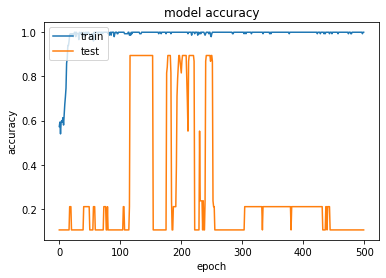

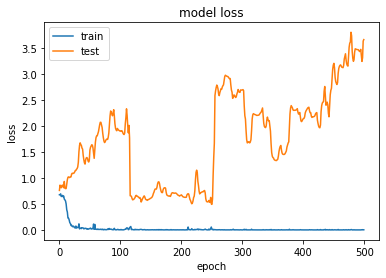

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()